## Enrichments from NAM flags

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from IPython.display import display, Markdown
%matplotlib inline

In [2]:
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
from scipy.spatial.distance import pdist, squareform

In [3]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
processed_dir = TOP + 'data/processed/'
figures_dir = TOP + 'reports/figures/'

In [4]:
LIB = TOP+'src/models/'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

In [5]:
from model_functions import *

In [7]:
df = pd.read_excel(interim_dir+'final_new_universe_wNAMS_091123.xlsx', index_col = [0])

In [8]:
df['NAM'] = np.where(df['Immune'].notnull() | df['DNT'].notnull() | df['ZF'].notnull() | \
         df['hDIO1'].notnull() | df['hDIO2'].notnull()| df['hDIO3'].notnull() | df['xDIO3'].notnull() | df['hIYD'].notnull() | \
                      df['XIYD'].notnull() | df['hTBG'].notnull() | \
                      df['hTPO'].notnull() |  df['NR_ESR1'].notnull() | \
                      df['NR_NRF2'].notnull() | df['NR_PPAR'].notnull() | \
                      df['NR_PXR'].notnull() | \
                      df['NR_RXR'].notnull(),       1,0)

In [10]:
df.columns

Index(['dtxsid', 'DSSTox_QC-Level', 'Substance_Name', 'Substance_CASRN',
       'Substance_Type', 'smiles', 'Structure_InChI', 'Structure_InChIKey',
       'Structure_Formula', 'Structure_MolWt',
       ...
       'xDIO3', 'hIYD', 'XIYD', 'hTBG', 'hTPO', 'Immune', 'TK_PlasBind',
       'TK_Metab', 'TK_Struc_Endo', 'NAM'],
      dtype='object', length=113)

In [11]:
mycats = {}
for i, group in df.groupby('group_str'):
    mycats[i] = group[['dtxsid',
 'Substance_Name',
 'smiles',
 'Structure_MolWt',
 'TSCA_STATUS','qc',
 'qc_httk',
 'NR_ESR1',
 'NR_PPAR',
 'NR_NRF2',
 'NR_RXR',
 'NR_PXR',
 'ZF',
 'DNT',
 'hDIO1',
 'hDIO2',
 'hDIO3',
 'xDIO3',
 'hIYD',
 'XIYD',
 'hTBG',
 'hTPO',
 'Immune',
 'TK_PlasBind',
 'TK_Metab',
 'TK_Struc_Endo', 'NAM']]

In [12]:
nams_dict = {k: v for k, v in mycats.items() if v['NAM'].sum() >= 5}

In [13]:
nams_dict.keys()

dict_keys(["('Fluorotelomer PFAA precursors', 'gte7', nan, nan)", "('Fluorotelomer PFAA precursors', 'lt7', 2.0, 3.0)", "('Other aliphatics', 'gte7', 2.0, nan)", "('Other aliphatics', 'gte7', 3.0, 2.0)", "('Other aliphatics', 'lt7', 3.0, 4.0)", "('PFAAs', 'gte7', nan, nan)", "('PFAAs', 'lt7', 1.0, nan)", "('PFAAs', 'lt7', 2.0, nan)", "('PFAAs', 'lt7', 4.0, nan)"])

In [14]:
def prep_nam(df):
    df1 = df[df['NAM'] == 1]
    return df1

In [15]:
nam = {}
for k, v in nams_dict.items():
    nam[k] = prep_nam(v)

In [16]:
all_chem = {}
for k,v in nams_dict.items():
    all_chem[k] = mk_fp(v)

In [17]:
dist_chem = {k:distance_matrix(v) for k,v in all_chem.items()}

In [18]:
#dist_chem

In [19]:
nam_chem = {}
for k,v in nam.items():
    nam_chem[k] = mk_fp(v)

In [20]:
nam_bio = {}
for k, v in nam.items():
    v1 = v.set_index('dtxsid')
    nam_bio[k] = v1.iloc[:, 6:-2]

In [22]:
#nam_bio

In [72]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

In [24]:
pfas_txps3 = pd.read_csv(external_dir+'pfas_txps_090923.csv', index_col = [0])

In [25]:
pfas_txps3.rename(columns = {'M_NAME': 'dtxsid'}, inplace = True)

In [26]:
#pd.merge(nams_dict["('Fluorotelomer PFAA precursors', 'gte7', nan, nan)"]['dtxsid'], pfas_txps3, on = 'dtxsid', how = 'left')

In [27]:
all_chem_4 = {}
for k,v in nams_dict.items():
    all_chem_4[k] = pd.merge(nams_dict[k]['dtxsid'], pfas_txps3, on = 'dtxsid', how = 'left').set_index('dtxsid')

In [28]:
dist_chem_4 = {k:distance_matrix(v) for k,v in all_chem_4.items()}

In [29]:
#nam["('Fluorotelomer PFAA precursors', 'gte7', nan, nan)"]

In [30]:
nam_chem_3 = {}
for k,v in nam.items():
    nam_chem_3[k] = pd.merge(nam[k]['dtxsid'], pfas_txps3, on = 'dtxsid', how = 'left').set_index('dtxsid')

In [31]:
nam_chem_3 = {k:distance_matrix(v) for k,v in nam_chem_3.items()}

In [32]:
df_nams = df[df['NAM']==1][['dtxsid',
 
 'NR_ESR1',
 'NR_PPAR',
 'NR_NRF2',
 'NR_RXR',
 'NR_PXR',
 'ZF',
 'DNT',
 'hDIO1',
 'hDIO2',
 'hDIO3',
 'xDIO3',
 'hIYD',
 'XIYD',
 'hTBG',
 'hTPO',
 'Immune',
 'TK_PlasBind',
 'TK_Metab',
 'TK_Struc_Endo']]

In [33]:
df_nams = pd.merge(df_nams, pfas_txps3, on = 'dtxsid', how = 'left')

In [34]:
df_nams1 = df_nams.set_index('dtxsid')

In [35]:
df_nams1.iloc[:,:19] = df_nams1.iloc[:,:19].applymap(lambda x: 1 if x >0 else x)

In [36]:
#df_nams1.to_csv(external_dir+'nams_binary.csv')

In [37]:
import scipy.stats as stats
from scipy.stats import chi2_contingency

In [49]:
a1 = pd.crosstab(df_nams1['NR_ESR1'], df_nams1['pfas_bond:X[notF]_CFX_generic']).sort_index(ascending = False)

In [50]:
a1[[1,0]]

pfas_bond:X[notF]_CFX_generic,1,0
NR_ESR1,,
1.0,4,13
0.0,2,105


In [51]:
res_txp = []
for i, col in df_nams1.iloc[:,19:].items():
    for j, col in df_nams1.iloc[:,0:19].items(): 
        if pd.crosstab(df_nams1[i], df_nams1[j]).shape == (2,2):
            a = pd.crosstab(df_nams1[j], df_nams1[i])
            a = a.sort_index(ascending = False)
            a = a[[1,0]]
            tp, tn, fp, fn = a.iloc[0,0], a.iloc[1,1], a.iloc[1,0], a.iloc[0,1]
            oddsratio, pvalue = stats.fisher_exact(a, alternative = 'greater')
            res_txp.append([i, j, oddsratio, pvalue, tp])

In [52]:
def convert(lst):
    df = pd.DataFrame(lst)
    df.rename(columns = {0: 'TxP', 1: 'Assay', 2 : 'OR', 3: 'p', 4:'tp'}, inplace = True)
    df = df.sort_values(by=['OR','p'], ascending = [False, True])
    return df

In [53]:
res_enrich = convert(res_txp)
#res_enrich

In [54]:
res_enrich = res_enrich[res_enrich['Assay'] != 'TK_Struc_Endo']

In [110]:
#res_enrich[(res_enrich['p']<0.05) & (res_enrich['OR'] >3) ].shape

In [55]:
res_enrich_df = res_enrich[(res_enrich['p']<0.05) & (res_enrich['OR'] >3) ]

In [105]:
res_enrich_df.to_csv(interim_dir+'enriched_TxPs.csv')

In [57]:
res_enrich_df

enriched_dict = {}
for e in res_enrich_df['Assay'].unique():
    enriched_dict[e] = res_enrich_df[res_enrich_df['Assay']  ==e]['TxP'].tolist()

In [70]:
enriched_dict['TK_PlasBind']

['pfas_bond:S=O_sulfonyl_generic_CF',
 'pfas_bond:S(=O)O_sulfonicAcid_acyclic_(chain)_SCF',
 'pfas_chain:perF-linear_C9_plus',
 'pfas_bond:C~Z_CF2CF2-Z',
 'pfas_bond:COC_ether_aliphatic_FCOCF',
 'pfas_bond:COC_ether_FCOC',
 'pfas_chain:perF-linear_cap_C8_excl_mod',
 'pfas_chain:perF-linear_C8_plus',
 'pfas_chain:perF-linear_C7_plus',
 'pfas_chain:perF-linear_cap_C6_plus']

In [71]:
def enriched_nams(df):
        test_rev = []
        for i, row in df.iterrows():
            if (row['pfas_bond:S(=O)N_sulfonylamide_SCF'] == 1) | (row['pfas_bond:S~N_generic_CF'] == 1) | (row['pfas_bond:S=O_sulfonyl_generic_CF'] ==1) \
            | (row['pfas_chain:perF-linear_C8_plus'] ==1) | (row['pfas_bond:C~Z_CF2CF2-Z'] ==1) | (row['pfas_chain:perF-linear_cap_C8_excl_mod'] ==1):
                test_rev.append([i, 'ZF'])
            if (row['pfas_chain:perF-linear_C8_plus'] == 1) | (row['pfas_bond:X[notF]_CFX_Cl'] == 1) | (row['pfas_chain:perF-linear_C7_plus'] ==1):
                test_rev.append([i, 'NR_NRF2'])
            if (row['pfas_bond:C(=O)O_carboxylicEster_acyclic_OCCF'] == 1) | (row['pfas_chain:FT_n1_O'] == 1) | (row['pfas_chain:FT_n1_hetero'] ==1):
                test_rev.append([i, 'hDIO1'])
            if (row['pfas_bond:X[notF]_CFX_Cl'] == 1) | (row['pfas_chain:FT_n3_hetero'] == 1) | (row['pfas_chain:FT_n3_O'] ==1):
                test_rev.append([i, 'NR_RXR'])
            if (row['pfas_bond:X[notF]_CFX_I'] == 1) | (row['pfas_bond:X[notF]_CFX_generic'] == 1) | (row['pfas_bond:X[notF]_CFCX_I'] ==1) | (row['pfas_bond:COH_alcohol_pri-alkyl_CF'] ==1) | (row[ 'pfas_bond:X[notF]_CFCX_generic'] ==1):
                test_rev.append([i, 'NR_ESR1'])
            if (row['pfas_bond:C=O_carbonyl_generic_CF'] == 1) | (row['pfas_bond:X[notF]_CFCX_Cl'] == 1) | (row['pfas_bond:C(=O)O_carboxylicAcid_generic_CF'] ==1):
                test_rev.append([i, 'NR_PPAR'])
            if (row['pfas_bond:S=O_sulfonyl_generic_CF'] == 1) | (row['pfas_chain:perF-linear_cap_C8_excl_mod'] == 1) | (row['pfas_chain:perF-linear_C8_plus'] ==1) \
            | (row['pfas_bond:C~Z_CF2CF2-Z'] ==1) | (row['pfas_chain:perF-linear_C7_plus'] ==1) | (row['pfas_bond:OZ_oxide_hydroxy_CF'] ==1) | (row['pfas_bond:S(=O)O_sulfonicAcid_acyclic_(chain)_SCF'] ==1):
                test_rev.append([i, 'NR_PXR'])
            if  (row['pfas_chain:FT_n2_C=O'] == 1):
                test_rev.append([i, 'Immune'])
            if (row['pfas_bond:S(=O)N_sulfonylamide_SCF'] == 1) | (row['pfas_bond:S~N_generic_CF'] == 1):
                test_rev.append([i, 'DNT'])
            if (row['pfas_bond:S=O_sulfonyl_generic_CF'] == 1) | (row['pfas_bond:S(=O)O_sulfonicAcid_acyclic_(chain)_SCF'] == 1) | (row['pfas_chain:perF-linear_C9_plus'] ==1) | (row['pfas_chain:perF-linear_C7_plus'] ==1) \
            | (row['pfas_bond:C~Z_CF2CF2-Z'] ==1) | (row['pfas_bond:COC_ether_aliphatic_FCOCF'] ==1) | (row['pfas_chain:perF-linear_cap_C8_excl_mod'] ==1) | (row['pfas_chain:perF-linear_C8_plus'] ==1) | (row['pfas_chain:perF-linear_cap_C6_plus'] ==1):
                test_rev.append([i, 'TK_PlasBind'])
            else:
                test_rev.append([i, 'No flag'])
        return pd.DataFrame(test_rev, columns = ['dtxsid', 'NAM_SARs'])   

In [72]:
pfas_txps_new = pd.read_csv(interim_dir+'new_inv_4TxPs_PFAS_out.txt',sep = ';')

In [74]:
pfas_txps_new
pfas_txps_new1 = pfas_txps_new.set_index('M_NAME')

In [75]:
pred_nams = enriched_nams(pfas_txps_new1)

In [78]:
pred_nams_pvt = pred_nams.pivot(index = 'dtxsid', columns = ['NAM_SARs'], values = 'NAM_SARs' )

In [79]:
pred_nams_pvt = pred_nams_pvt.applymap(lambda x : 1 if pd.notnull([x]) else 0)

In [80]:
pred_nams_pvt.columns.name = None

In [81]:
pred_nams_pvt.columns = ['pred_'+e for e in pred_nams_pvt.columns]

In [82]:
pred_nams_pvt = pred_nams_pvt.reset_index()

In [84]:
writer = pd.ExcelWriter(interim_dir+'predicted_NAMs_091123.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
pred_nams_pvt.to_excel(writer, sheet_name = 'predicted_NAMS_universe')


writer.close()

In [85]:
df2 = pd.merge(df, pred_nams_pvt, on = 'dtxsid', how = 'left')

In [108]:
writer = pd.ExcelWriter(interim_dir+'final_landscape_with_predicted_NAMs_091123.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df2.to_excel(writer)


writer.close()

In [86]:
df3 = df2[['dtxsid','group_str','qc',
 'qc_httk',
 'NR_ESR1',
 'NR_PPAR',
 'NR_NRF2',
 'NR_RXR',
 'NR_PXR',
 'ZF',
 'DNT',
 'hDIO1',
 'hDIO2',
 'hDIO3',
 'xDIO3',
 'hIYD',
 'XIYD',
 'hTBG',
 'hTPO',
 'Immune',
 'TK_PlasBind',
 'TK_Metab',
 'TK_Struc_Endo','pred_DNT',
 'pred_Immune',
 'pred_NR_ESR1',
 'pred_NR_NRF2',
 'pred_NR_PPAR',
 'pred_NR_PXR',
 'pred_NR_RXR',
 'pred_TK_PlasBind',
 'pred_ZF',
 'pred_hDIO1',
          'pred_No flag']]
     

In [87]:
df3.iloc[:,4:23] = df3.iloc[:,4:23].applymap(lambda x: 1 if x>0 else x)

/tmp/ipykernel_42564/2266291653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.iloc[:,4:23] = df3.iloc[:,4:23].applymap(lambda x: 1 if x>0 else x)


In [88]:
from sklearn.metrics import confusion_matrix,roc_auc_score, recall_score, accuracy_score

In [89]:
tuples = []

for i in range(len(df3.columns.tolist()[4:23])):
    for j in range(len(df3.columns.tolist()[23:])):
        element1 = df3.columns.tolist()[4:23][i]
        element2 = df3.columns.tolist()[23:][j]
        if element1 in element2:
           tuples.append([element1, element2])

In [90]:
def metrics_nams(df):
    metrics = []
    for e in tuples:
        me = df[e].dropna()
        x = pd.crosstab(me[e[0]], me[e[1]])
        tn, fp, fn, tp = x.iloc[0,0], x.iloc[0,1], x.iloc[1,0], x.iloc[1,1]
        sensitivity = tp/(tp+fn)
        specificity = tn/(tn+fp)
        accuracy = (tp+tn)/(tp+tn+fp+fn)
        a = roc_auc_score(me.iloc[:,0], me.iloc[:,1])
        b = recall_score(me.iloc[:,0], me.iloc[:,1])
        c = accuracy_score(me.iloc[:,0], me.iloc[:,1])
        metrics.append([e,a,c,b, specificity])
    return metrics

In [104]:
round(pd.DataFrame(metrics_nams(df3), columns = ['comparison', 'ROC_AUC_score','Accuracy',  'Sensitivity', 'Specificity']),2).to_csv(interim_dir+'performance_NAM_flags.csv')

In [92]:
myresults = {}
for i, group in df3.groupby('group_str'):
    myresults[i] = group

In [101]:
case_study = myresults[ "('PFAAs', 'gte7', nan, nan)"].set_index('dtxsid').iloc[:,3:][['NR_ESR1', 'NR_PPAR', 'NR_NRF2', 'NR_RXR', 'NR_PXR', 'ZF', 'DNT',
       'hDIO1', 'hDIO2', 'hDIO3', 'xDIO3', 'hIYD', 'XIYD', 'hTBG', 'hTPO',
       'Immune', 'TK_PlasBind', 'TK_Metab', 'TK_Struc_Endo','pred_NR_ESR1','pred_NR_PPAR', 'pred_NR_NRF2','pred_NR_RXR','pred_NR_PXR','pred_ZF', 'pred_DNT','pred_hDIO1','pred_Immune', 'pred_TK_PlasBind','pred_No flag']]

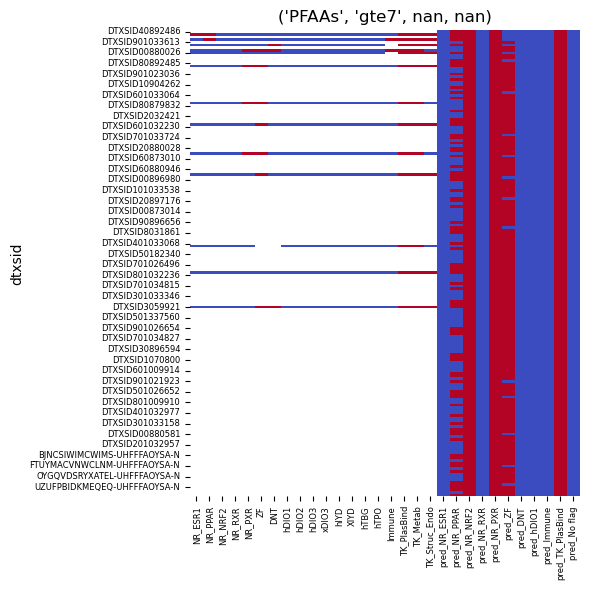

In [103]:
f1, ax = plt.subplots(figsize = (6,6) )
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
ax.set_title("('PFAAs', 'gte7', nan, nan)")
sns.heatmap(case_study, cmap = 'coolwarm', ax = ax,  cbar = False, cbar_kws={"shrink": 0.5})
plt.tight_layout()
f1.savefig(figures_dir+'predicted_NAM_example.png');